In [2]:
import os
import numpy as np
import pandas as pd
import desispec.io
from desispec.coaddition import coadd_cameras
from astropy.io import fits
import h5py
import random

np.random.seed(123)  # Set seed for NumPy's random generator
random.seed(123)     # Set seed for Python's random module

# Function to extract data from HDF5 files
def extract_data_from_hdf5(file_path):
    classifier, name, spectra, redshift = [], [], [], []
    with h5py.File(file_path, "r") as hdf5_file:
        classifier = hdf5_file["classifier"][:]
        name = hdf5_file["name"][:]
        spectra = hdf5_file["spectra"][:]
        redshift = hdf5_file["redshift"][:]
    return classifier, [n.decode() for n in name], spectra, redshift

# Function to process and modify QSO fluxes
def process_qso_fluxes(fits_directory, hdf5_directory, output_directory, lens_percentage=.1, num_files=None):
    # List all HDF5 files in the directory and sort them by name
    hdf5_files = sorted([f for f in os.listdir(hdf5_directory) if f.endswith(".h5")])

    # Initialize arrays to store data
    all_classifierselg, all_nameselg, all_spectraelg, all_redshiftselg = [], [], [], []

    # Iterate over HDF5 files in the directory
    for filename in hdf5_files:
        file_path = os.path.join(hdf5_directory, filename)

        # Extract data from the HDF5 file without filtering
        classifier, name, spectra, redshift = extract_data_from_hdf5(file_path)

        # Append the data to the respective arrays
        all_classifierselg.extend(classifier)
        all_nameselg.extend(name)
        all_spectraelg.extend(spectra)
        all_redshiftselg.extend(redshift)

    print(f"Total ELG entries: {len(all_redshiftselg)}")
    
    # List all QSO FITS files in the directory
    fits_files = sorted([f for f in os.listdir(fits_directory) if f.endswith(".fits")])

    if num_files is not None:
        fits_files = fits_files[:num_files]

    # Initialize arrays to store aggregated QSO data
    all_qso_fluxes = []
    all_targetids_qso = []
    all_redshifts_qso = []
    all_ivar = []
    file_qso_indices = []

    # Iterate over FITS files to aggregate data
    for fits_file in fits_files:
        file_path = os.path.join(fits_directory, fits_file)

        # Read the stacked spectra
        qsos = desispec.io.read_spectra(file_path)

        # Access the extra catalog data
        extra_catalog = qsos.extra_catalog

        # Extract TARGETID and Z arrays
        targetids_qso = extra_catalog['TARGETID']
        redshifts_qso = extra_catalog['Z']

        # Combine camera spectra for QSOs
        qso_fluxes = []
        qso_ivar = []
        for i2 in range(len(qsos)):
            coadd = coadd_cameras(qsos[i2])
            qso_fluxes.append(coadd.flux['brz'][0])
            qso_ivar.append(coadd.ivar['brz'][0])

        # Append data to the aggregated arrays
        all_qso_fluxes.extend(qso_fluxes)
        all_ivar.extend(qso_ivar)
        all_targetids_qso.extend(targetids_qso)
        all_redshifts_qso.extend(redshifts_qso)
        file_qso_indices.append(len(all_qso_fluxes))

    all_qso_fluxes = np.array(all_qso_fluxes)
    all_ivar = np.array(all_ivar)
    all_targetids_qso = np.array(all_targetids_qso)
    all_redshifts_qso = np.array(all_redshifts_qso)
    
    print(f"Total QSO entries: {len(all_redshifts_qso)}")
    
    # Initialize a labels array with zeros
    num_qsos = len(all_qso_fluxes)
    labels = np.zeros(num_qsos, dtype=int)
    elg_redshifts_for_qsos = np.zeros(num_qsos)
    elg_names_for_qsos = np.array([""] * num_qsos, dtype=object)

    # Handling 100% lensing when lens_percentage is 1.0
    if lens_percentage == 1.0:
        valid_qso_indices = np.where(all_redshifts_qso <= 1.68)[0]
        print(f"Number of valid QSOs for lensing: {len(valid_qso_indices)}")
    else:
        # Randomly sample a percentage of the QSOs, regardless of redshift
        num_modify = int(lens_percentage * num_qsos)
        valid_qso_indices = random.sample(range(num_qsos), num_modify)

    # List to keep track of successfully modified indices
    modified_indices = []

    # Superimpose ELG fluxes onto QSO fluxes based on the redshift condition
    for i in valid_qso_indices:
        if i >= len(all_redshiftselg):
            print(f"QSO index {i} exceeds ELG redshift data size, skipping.")
            continue
        
        elg_candidates = np.where(all_redshiftselg > all_redshifts_qso[i])[0]
        if elg_candidates.size > 0:
            elg_idx = random.choice(elg_candidates)
            elg_flux = pd.DataFrame(all_spectraelg[elg_idx])[1].values

            # Generate adjusted_factor from a normal distribution
            while True:
                adjusted_factor = np.random.normal(4, 2)
                if adjusted_factor >= 2 and adjusted_factor <= 4:
                    break

            all_qso_fluxes[i] += elg_flux * adjusted_factor
            labels[i] = 1  # Set the label to 1 to indicate modification
            elg_redshifts_for_qsos[i] = all_redshiftselg[elg_idx]
            elg_names_for_qsos[i] = all_nameselg[elg_idx]
            modified_indices.append(i)

    print(f"Number of modified QSOs: {len(modified_indices)}")

    # Output the modified data into separate files based on the original distribution
    start_idx = 0
    for idx, fits_file in enumerate(fits_files):
        end_idx = file_qso_indices[idx]

        # Create a new HDUList object for the modified data
        hdu_list = fits.HDUList()

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdu_list.append(primary_hdu)

        # Create a BinaryTableHDU for the modified fluxes
        col1 = fits.Column(name='TARGETID', format='K', array=all_targetids_qso[start_idx:end_idx])
        col2 = fits.Column(name='Z', format='D', array=all_redshifts_qso[start_idx:end_idx])
        col3 = fits.Column(name='FLUX', format='PD()', array=all_qso_fluxes[start_idx:end_idx])
        col4 = fits.Column(name='ivar', format='PD()', array=all_ivar[start_idx:end_idx])
        col5 = fits.Column(name='LABEL', format='I', array=labels[start_idx:end_idx])  # Add labels column
        col6 = fits.Column(name='ELG_Z', format='D', array=elg_redshifts_for_qsos[start_idx:end_idx])  # Add ELG redshift column
        col7 = fits.Column(name='ELG_NAME', format='A20', array=elg_names_for_qsos[start_idx:end_idx])  # Add ELG name column
        cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7])
        hdu = fits.BinTableHDU.from_columns(cols)

        hdu_list.append(hdu)

        # Write to a new FITS file
        output_file_path = os.path.join(output_directory, f"modified_test_set_Phase2_{fits_file}")
        hdu_list.writeto(output_file_path, overwrite=True)

        start_idx = end_idx

    # Output the results
    print("Original QSO fluxes shape:", all_qso_fluxes.shape)
    print("Labels array shape:", labels.shape)
    print("Number of modified fluxes:", np.sum(labels))

    # Ensure the changes are reflected in a new array for further analysis
    resulting_fluxes = all_qso_fluxes

# Example usage
fits_directory = os.path.expandvars('$SCRATCH/MainQSO')
hdf5_directory = 'fastspec_ELG1'
output_directory = os.path.expandvars('$PSCRATCH')

process_qso_fluxes(fits_directory, hdf5_directory, output_directory, lens_percentage=.1, num_files=1)


Total ELG entries: 16500
INFO:spectra.py:391:read_spectra: iotime 3.639 sec to read desi_bright_qso_batch2.fits at 2024-10-31T09:50:26.650836
Total QSO entries: 3547
Number of modified QSOs: 306
Original QSO fluxes shape: (3547, 7781)
Labels array shape: (3547,)
Number of modified fluxes: 306



-----------------------------------------------
# I know that the QSO range is from ~0 to 1.8 so i wanted to perform a check in the case that if any qsos where selected as among the 10% with z greater than 1.6 its possible that they could have been used for the lens calculationv \




In [5]:
import os
from astropy.io import fits
import numpy as np

# Define the path to the folder containing the FITS files
fits_folder_path = os.path.expandvars('$SCRATCH/MainQSO/TrainFlux2/')

# Loop through all files in the folder
for file_name in os.listdir(fits_folder_path):
    if file_name.endswith('.fits'):
        fits_file_path = os.path.join(fits_folder_path, file_name)
        
        print(f"\nProcessing file: {file_name}")
        
        # Open the FITS file and ensure it's closed after use
        with fits.open(fits_file_path, memmap=True) as hdul:  # memmap=True to reduce memory usage
            binary_table_hdu = hdul[1]
            data = binary_table_hdu.data

            # Access relevant data from columns
            redshifts = data['Z']
            labels = data['LABEL']

            # Find indices where redshifts > 1.69 and labels == 1
            QSO_Z = np.where(redshifts > 1.69)[0]
            Label_Lens = np.where(labels == 1)[0]
            common_indices = np.intersect1d(QSO_Z, Label_Lens)

            # Print "Yes" if common indices are found, otherwise "No"
            if len(common_indices) > 0:
                print("Yes")
            else:
                print("No")

        # The file is automatically closed after exiting the 'with' block


NotADirectoryError: [Errno 20] Not a directory: 'modified_test_set_desi_bright_qso_batch2.fits'

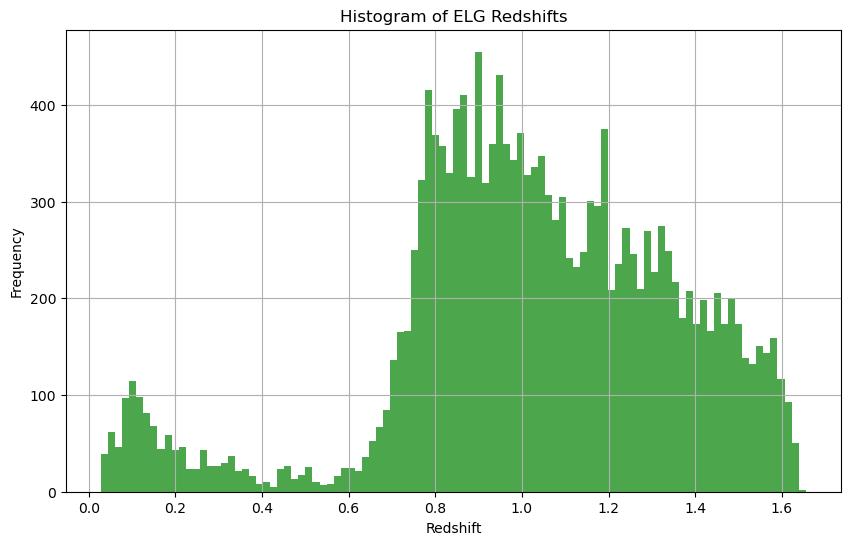

Total number of redshifts: 16500


In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

np.random.seed(123)  # Set seed for NumPy's random generator

# Function to extract data from HDF5 files
def extract_data_from_hdf5(file_path):
    classifier, name, spectra, redshift = [], [], [], []
    with h5py.File(file_path, "r") as hdf5_file:
        classifier = hdf5_file["classifier"][:]
        name = hdf5_file["name"][:]
        spectra = hdf5_file["spectra"][:]
        redshift = hdf5_file["redshift"][:]
    return classifier, [n.decode() for n in name], spectra, redshift

# Function to process ELG data and show histogram of redshifts
def process_elg_redshifts(hdf5_directory):
    # List all HDF5 ELG files in the directory and sort them by name
    hdf5_files = sorted([f for f in os.listdir(hdf5_directory) if f.endswith(".h5")])

    all_redshiftselg = []  # Initialize an empty list for redshifts

    # Iterate over HDF5 files in the directory
    for filename in hdf5_files:
        file_path = os.path.join(hdf5_directory, filename)

        # Extract redshift data from the HDF5 file
        _, _, _, redshift = extract_data_from_hdf5(file_path)

        # Append the redshifts to the array
        all_redshiftselg.extend(redshift)

    # Convert redshift list to a NumPy array for easier manipulation
    all_redshiftselg = np.array(all_redshiftselg)

    # Plot the histogram of the redshift data
    plt.figure(figsize=(10, 6))
    plt.hist(all_redshiftselg, bins=100, color='green', alpha=0.7)
    plt.title('Histogram of ELG Redshifts')
    plt.xlabel('Redshift')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    print(f"Total number of redshifts: {len(all_redshiftselg)}")

# Example usage
hdf5_directory = 'fastspec_ELG1'  # Directory containing ELG HDF5 files
process_elg_redshifts(hdf5_directory)


------------------------------------------------------------------------------------------

# Lets try to open a file

In [6]:
import os
import numpy as np
import pandas as pd
import desispec.io
from desispec.coaddition import coadd_cameras
from astropy.io import fits
import h5py
import random


In [10]:

# Define the path to the FITS file you want to open
fits_file_path = os.path.join(os.path.expandvars('$SCRATCH/MainQSO/'), 'Redshift/modified_desi_bright_qso_batch2.fits')

# Open the FITS file
with fits.open('modified_test_set_desi_bright_qso_batch2.fits') as hdul:
    # Print the HDU (Header/Data Unit) list
    hdul.info()
    
    # Access the primary HDU
    primary_hdu = hdul[0]
    print("Primary HDU Header:")
    print(primary_hdu.header)
    
    # Access the binary table HDU
    binary_table_hdu = hdul[1]
    data = binary_table_hdu.data

    # Print the column names
    print("\nColumn names in the binary table HDU:")
    print(data.columns.names)
    
    # Access data from columns
    target_ids = data['TARGETID']
    redshifts = data['Z']
    fluxes = data['FLUX']
    labels = data['LABEL']
    elg_fluxes = data['ELG_z']  # Access the ELG flux column
    ename = data['ELG_NAME']
    ivar = data['ivar']

    # Print some example data
    print("\nExample data:")
    print("TARGETID:", target_ids[:5])
    print("Redshifts:", redshifts[:5])
    print("Fluxes:", fluxes[:5])
    print("Labels:", labels[:5])
    print("ELG Fluxes:", elg_fluxes[:5])  # Print some example ELG fluxes
    print("ELG name:", ename[:5])

# Output some information about the data
print("\nNumber of entries:", len(data))


Filename: modified_test_set_desi_bright_qso_batch2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   3547R x 7C   [K, D, PD(7781), PD(7781), I, D, 20A]   
Primary HDU Header:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                        

In [11]:
    i = 1
    print("\nExample data:")
    print("TARGETID:", target_ids[i])
    print("Redshift:", redshifts[i])
    print("Fluxes:", fluxes[i])
    print("Labels:", labels[i])
    print("ELG Redshift:", elg_fluxes[i])
    print("ELG NAME", ename[i])
    print("ELG ivar", ivar[i])# Print some example ELG fluxes



Example data:
TARGETID: 39627930178947635
Redshift: 1.4692515123279644
Fluxes: [5.31930557 7.60196323 5.92997294 ... 1.00796063 1.19583468 0.86463271]
Labels: 1
ELG Redshift: 1.5420622602746439
ELG NAME 39627751564511846
ELG ivar [ 0.1117608   0.1377531   0.16642864 ... 13.5025959  27.44604683
 37.54445267]


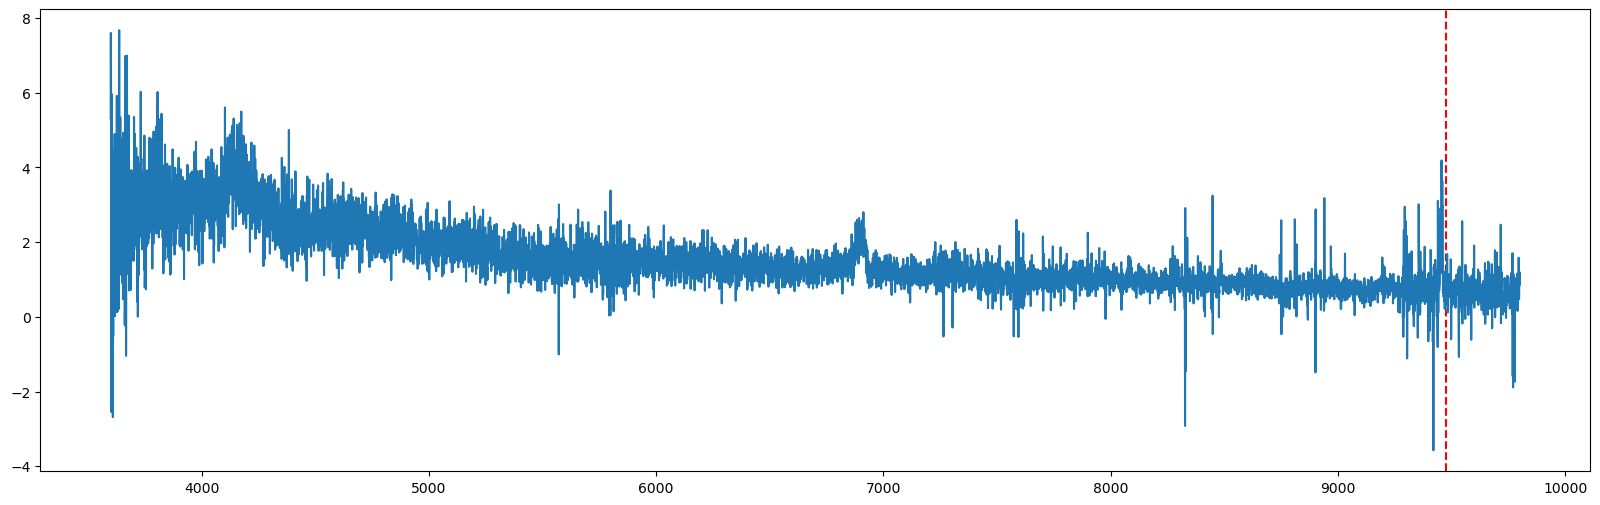

In [14]:
import matplotlib.pyplot as plt
Flux = fluxes[i]
plt.figure(figsize = (20,6))
r = 3727 * (1 + elg_fluxes[i])
plt.axvline(r, color = 'red', linestyle = '--')

wavelength_min = 3600  # in nm
wavelength_max = 9800  # in nm

# Create an array of 7781 linearly spaced values within this range
pixels = np.linspace(wavelength_min, wavelength_max, 7781)



plt.plot(pixels, fluxes[i])
#plt.plot(pixels, 1/np.sqrt(ivar[i]))


In [56]:
r

8177.924405153268

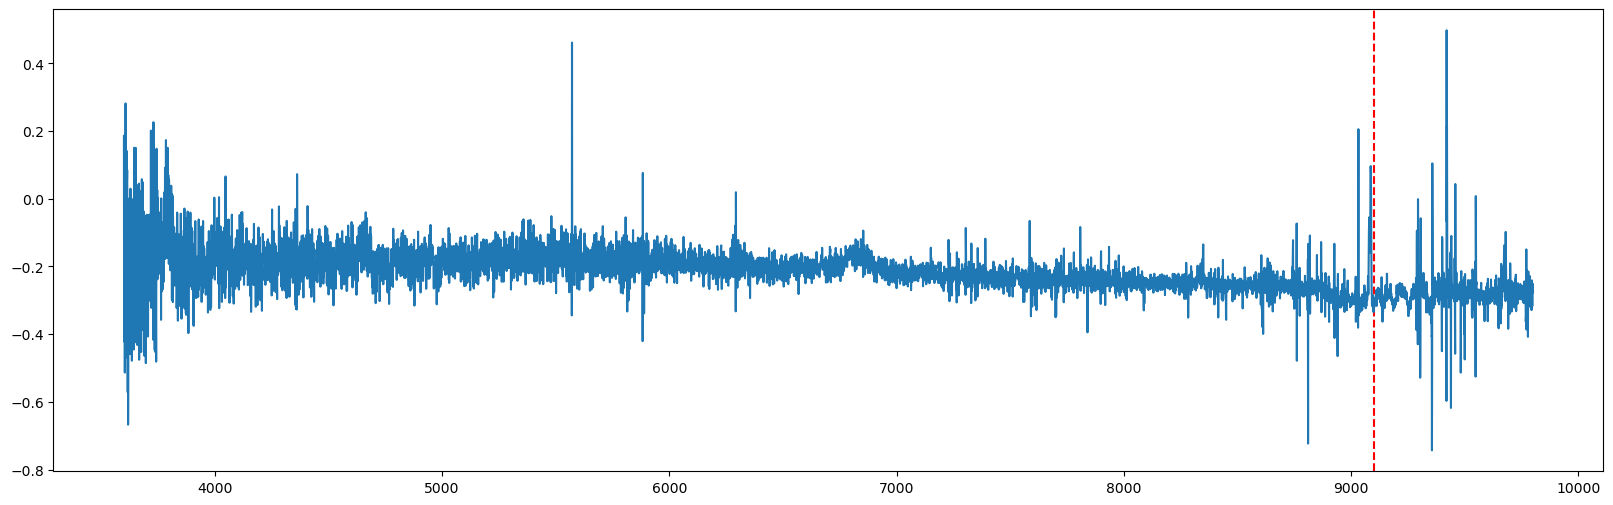

In [23]:
import matplotlib.pyplot as plt
Flux = fluxes[i]
plt.figure(figsize = (20,6))
rj = 3727 * (1 + elg_fluxes[j])
plt.axvline(rj, color = 'red', linestyle = '--')

wavelength_min = 3600  # in nm
wavelength_max = 9800  # in nm

# Create an array of 7781 linearly spaced values within this range
pixels = np.linspace(wavelength_min, wavelength_max, 7781)



plt.plot(pixels, (fluxes[j] - np.mean(fluxes[j])/np.std(fluxes[j]))/np.max(fluxes[j]))
